# Домашнее задание 3: Imitation Learning (Behavioral Cloning и DAgger)

В этом задании вы познакомитесь с методами **имитационного обучения (Imitation Learning)** — подходом к обучению агентов, при котором они учатся напрямую копировать поведение эксперта, не получая при этом явного сигнала награды от среды. Такие методы особенно полезны, когда:
- награда разрежена или недоступна,
- экспертное поведение легко продемонстрировать, но трудно формализовать,
- требуется быстро получить рабочую политику без длительного взаимодействия со средой.

Вы реализуете два ключевых алгоритма:
1. **Behavioral Cloning (BC)** — простейший метод, сводящийся к задаче регрессии: по состоянию предсказать действие эксперта.
2. **DAgger (Dataset Aggregation)** — итеративный метод, который решает проблему *covariate shift*, активно собирая опыт в тех состояниях, куда попадает обучаемая политика.

## План задания и распределение баллов

| Этап | Описание | Максимум баллов |
|------|---------|------------------|
| **1. Оценка эксперта** | Оценка производительности предобученного эксперта (жадная и стохастическая политики), реализация IQM и визуализация поведения | **3 балла** |
| **2. Сбор датасета** | Генерация датасета траекторий от эксперта и сохранение в HDF5 | **2 балла** |
| **3. Behavioral Cloning** | Реализация нейросетевой архитектуры, обучение BC и оценка качества | **5 баллов**<br>— 2 балла за `MLPBlock`<br>— 2 балла за `MLPActHead`<br>— 1 балл за обучение и оценку |
| **4. Анализ BC** | Исследование зависимости качества BC от размера датасета с использованием IQM и сравнением in/out-of-distribution оценок | **5 баллов** |
| **5. DAgger** | Реализация итеративного алгоритма DAgger, сбор новых данных с участием эксперта и анализ сходимости | **5 баллов** |
| **Итого** | | **20 баллов** |

> 💡 **Совет**: начните с малых экспериментов (например, 10 траекторий) для отладки, и только затем масштабируйтесь до полного датасета (1024 траектории). Это сэкономит время и ресурсы Colab.

Удачи!

## Установка среды

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash xvfb start
#     os.environ['DISPLAY'] = ':1'

!pip install dm_control>=1.0.34  #torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install shimmy[dm-control]
!pip install gymnasium
!pip install torchinfo

# import warnings; warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow")

## Проверка установки и рендеринг среды MuJoCo  
Убедитесь, что среда корректно установлена и можно получить изображения из неё.


In [2]:
import gymnasium as gym
import numpy as np
from dm_control import suite
from dm_control.suite.wrappers import pixels
from shimmy import DmControlCompatibilityV0

warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

### Обёртка для рендеринга в средах DeepMind Control Suite  
Поскольку оригинальная среда `dm_control` не предоставляет метод `.render()` в формате, совместимом с Gymnasium, мы создаём собственную обёртку `DmControlWithRender`.  
Эта обёртка добавляет метод `render()`, который использует встроенный рендерер MuJoCo для получения изображений заданного разрешения и с нужной камеры.

In [3]:
class DmControlWithRender(gym.Wrapper):
    def __init__(self, env, height=84, width=84, camera_id=0):
        super().__init__(env)
        self._height = height
        self._width = width
        self._camera_id = camera_id

    def render(self):
        # Access the underlying dm_control env
        dm_env = self.unwrapped._env
        return dm_env.physics.render(
            height=self._height,
            width=self._width,
            camera_id=self._camera_id
        )

### Фабрика среды (`make_env`)  
Функция `make_env` создаёт настраиваемую среду с поддержкой различных полезных обёрток из Gymnasium:

- **`domain`, `task`** — определяют конкретную задачу (например, `"cheetah"` / `"run"`).
- **`frame_stack`** — количество последовательных наблюдений, объединяемых в одно состояние (полезно при обучении на изображениях или для учёта динамики).
- **`flatten_frames`** — если включено, наблюдения (даже стекированные) преобразуются в одномерный вектор.
- **`render_enabled`** — добавляет возможность рендеринга через обёртку `DmControlWithRender`.
- **`record_stats`** — включает сбор статистики по эпизодам (награда, длина и т.д.).
- **`transform_reward`** — применяет нормализацию и ограничение награды (использовалось при обучении эксперта).
- **`hw`** — высота и ширина изображения при рендеринге. Рекомендуется использовать небольшие значения (например, 64) для ускорения работы; максимальное разрешение — 480×480.

Эта функция возвращает *thunk* — callable без аргументов, который создаёт и возвращает готовую среду. Такой подход удобен при векторизации сред (например, через `gym.vector.SyncVectorEnv`).

In [4]:
def make_env(
        domain,
        task,
        frame_stack=1,
        flatten_frames=True,
        render_enabled=True,
        record_stats=False,
        transform_reward=False,
        gamma=0.99,
        hw=64,
    ):
    def thunk():
        dm_env = suite.load(
            domain_name=domain,
            task_name=task,
            task_kwargs=None,
            environment_kwargs=None,
            visualize_reward=False,
        )
        env = DmControlCompatibilityV0(dm_env)
        env = gym.wrappers.FlattenObservation(env) # dict obs -> vector

        # Only add render method if needed (doesn't affect obs)
        if render_enabled:
            env = DmControlWithRender(env, height=hw, width=hw)

        # Observation is always numeric state → consistent!
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            env = gym.wrappers.DtypeObservation(env, np.float32)
        if record_stats:
          env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        if transform_reward:
          env = gym.wrappers.NormalizeReward(env, gamma=gamma)
          env = gym.wrappers.TransformReward(env, lambda r: np.clip(r, -10, 10))

        # if frame_stack > 1:
        env = gym.wrappers.FrameStackObservation(env, stack_size=frame_stack)
        if flatten_frames:
            env = gym.wrappers.FlattenObservation(env)
        return env
    return thunk

**Инициализация среды**

Чтобы создать **одну** среду, достаточно вызвать фабричную функцию `make_env` и сразу же выполнить возвращаемый *thunk*:

```python
env = make_env(domain="cheetah", task="run", ...)()
```

Этот вызов создаёт экземпляр среды с заданными параметрами и готов к использованию: можно вызывать `env.reset()`, `env.step(action)` и т.д.

**Немного о векторизованных средах**  (`SyncVectorEnv`)

Однако при обучении агентов (особенно с помощью методов типа PPO или A2C) часто требуется **параллельно взаимодействовать с несколькими копиями среды**. Это позволяет:
- ускорить сбор данных за счёт параллелизма,
- уменьшить корреляцию между последовательными наблюдениями,
- стабилизировать обучение за счёт более разнообразного опыта.

Для этого в Gymnasium предусмотрен класс `SyncVectorEnv`, который объединяет несколько независимых сред в один векторизованный объект. Пример:

```python
from gymnasium.vector import SyncVectorEnv

num_envs = 4
envs = SyncVectorEnv([
    make_env(domain="cheetah", task="run", ...)
    for _ in range(num_envs)
])
```

Теперь `envs` ведёт себя как единая среда, но на самом деле управляет `num_envs` независимыми инстансами:
- `envs.reset()` возвращает массив наблюдений формы `(num_envs, obs_dim)`,
- `envs.step(actions)` принимает массив действий формы `(num_envs, act_dim)` и возвращает соответствующие награды, следующие состояния и флаги завершения.

Важно: `SyncVectorEnv` работает **синхронно** — все среды выполняются последовательно в основном потоке. Для настоящего параллелизма (в отдельных процессах) можно использовать `AsyncVectorEnv`, но для большинства учебных и прототипных задач `SyncVectorEnv` более чем достаточно и проще в отладке.

Этот подход используется, например, при загрузке эксперта: даже если нужна всего одна среда, её всё равно удобно оборачивать в `SyncVectorEnv`, чтобы архитектура агента (`Agent`) могла работать с батчами наблюдений (`envs.single_observation_space` и `envs.single_action_space` дают доступ к пространству одной среды).

In [10]:
# Cоздайте среду для задачи cheetah run
env = make_env(domain="cheetah", task="run", hw=240)()

In [11]:
env.observation_space

Box(-inf, inf, (17,), float32)

In [12]:
env.action_space

Box(-inf, inf, (6,), float64)

In [13]:
env.reset()

(array([-0.11576561,  0.04362103,  0.00998615,  0.04645669, -0.03359398,
        -0.02038797, -0.10415487, -0.09426226,  0.03448625,  0.00475672,
        -0.02140663,  0.04472575,  0.02431982,  0.06048748,  0.0457403 ,
         0.0329318 ,  0.04536325], dtype=float32),
 {'timestep.discount': None, 'timestep.step_type': <StepType.FIRST: 0>})

array([[[ 67, 101, 134],
        [ 67, 101, 134],
        [ 67, 101, 134],
        ...,
        [ 67, 101, 134],
        [ 67, 101, 134],
        [ 67, 101, 134]],

       [[ 67, 100, 134],
        [ 67, 100, 134],
        [ 67, 100, 134],
        ...,
        [ 67, 100, 134],
        [ 67, 100, 134],
        [ 67, 100, 134]],

       [[ 67, 100, 134],
        [ 67, 100, 134],
        [ 67, 100, 134],
        ...,
        [ 67, 100, 134],
        [ 67, 100, 134],
        [ 67, 100, 134]],

       ...,

       [[ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69],
        ...,
        [ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69]],

       [[ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69],
        ...,
        [ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69]],

       [[ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69],
        ...,
        [ 34,  52,  69],
        [ 34,  52,  69],
        [ 34,  52,  69]]], dtype=uint8)
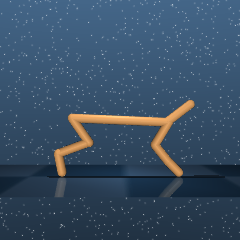

In [14]:
env.render()

Среда **MuJoCo** (в рамках DeepMind Control Suite) предоставляет множество различных задач, каждая из которых может рендериться с разных камер и имеет свои особенности динамики. Например:

- `walker / walk` — двуногий ходячий робот, обучающийся устойчиво передвигаться;
- `hopper / hop` — одноногий прыгающий агент;
- `cartpole / balance` — классическая задача балансировки на тележке;
- `reacher / easy` — манипулятор, который должен дотянуться до цели;
- `finger / spin` — задача вращения объекта с помощью двухпалого захвата;
- `cheetah / run` — четвероногий робот-гепард, обучающийся бегу вперёд.

Все эти среды поддерживают рендеринг с разных точек зрения (камер), что позволяет визуализировать поведение агента под разными углами. Однако для данного домашнего задания мы будем использовать только одну задачу — **`cheetah / run`**, так как именно для неё предоставлен экспертный агент и датасет.

## Загрузка экспертного агента

Загружаем предобученного эксперта — агента, обученного с помощью PPO.  

Для работы с этим заданием рекомендуется:

1. [Скачать папку](https://drive.google.com/drive/folders/1KAHb73CbOvmtGLKFVOHPUjQ44tFy74Mw?usp=sharing) с весами и конфигурацией к себе на **Google Диск**. В этой папке вы можете найти чекпоинты для 3х сред: `cheetah-run`, `hopper-hop` и `walker-run`, однако для этого задания нам понадобятся только `cheetah-run`.
2. Подключить Google Диск к среде Colab.


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


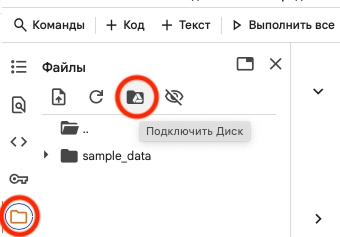

3. Убедиться, что путь `checkpoint_path` указывает на правильное расположение файлов `config.pt` и `checkpoint.pt`.

In [18]:
ls "/content/drive/MyDrive/cheetah-run-expert/"

checkpoint.pt  config.pt


In [19]:
checkpoint_path = "/content/drive/MyDrive/cheetah-run-expert//"
config_name = "config.pt"
checkpoint_name = "checkpoint.pt"

### Вспомогательные функции для нормализации наблюдений

Для стабильного обучения и оценки политик в RL часто используется **нормализация наблюдений** — приведение входных данных к нулевому среднему и единичной дисперсии.  
Класс `RunningMeanStd` реализует **онлайн-оценку среднего и дисперсии** по приходящим батчам данных, используя **параллельный алгоритм обновления моментов**.

Этот подход позволяет:
- эффективно обновлять статистики без хранения всей истории,
- корректно объединять статистики из разных источников (например, при распределённом сборе данных),
- избежать численной нестабильности, связанной с наивным подсчётом дисперсии.

In [20]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    """Updates the mean, var and count using the previous mean, var, count and batch values."""
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + torch.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class RunningMeanStd(nn.Module):
    """Tracks the mean, variance and count of values."""

    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, shape=(), epsilon=1e-4, dtype=torch.float32):
        super().__init__()
        """Tracks the mean, variance and count of values."""
        self.register_buffer("mean", torch.zeros(shape, dtype=dtype))
        self.register_buffer("var", torch.zeros(shape, dtype=dtype))
        self.register_buffer("count", torch.as_tensor(epsilon, dtype=dtype))

    def update(self, x):
        """Updates the mean, var and count from a batch of samples."""
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        batch_count = x.shape[0]
        self.__update_from_moments(batch_mean, batch_var, batch_count)

    def __update_from_moments(self, batch_mean, batch_var, batch_count):
        """Updates from batch mean, variance and count moments."""
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )

### Архитектура агента

Агент состоит из двух нейросетей:
- **Актёр (`actor_mean`)** — предсказывает среднее значение действия в виде гауссовой политики.
- **Критик (`critic`)** — оценивает ценность (value) текущего состояния.

Особенности:
- Используется **ортогональная инициализация весов** (`layer_init`).
- Логарифм стандартного отклонения (`actor_logstd`) обучается как глобальный параметр (не зависит от состояния).
- Наблюдения **нормализуются онлайн** с помощью `RunningMeanStd`.
- Для совместимости с Gymnasium и векторизованными средами агент принимает среду типа `SyncVectorEnv`, но работает и с одной средой. При инициализации в него нужно подать такую среду.

Метод `act_numpy` позволяет удобно вызывать агента из NumPy-кода (например, при сборе траекторий).

In [21]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, hidden_dim=64, obs_norm_eps=1e-8):
        super().__init__()
        input_dim = np.array(envs.single_observation_space.shape).prod()

        self.obs_rms = RunningMeanStd(input_dim)
        self.obs_norm_eps = obs_norm_eps

        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def update_obs_rms(self, x):
        self.obs_rms.update(x)

    def normalize_obs(self, x):
        normalized_obs = (x - self.obs_rms.mean) / torch.sqrt(self.obs_rms.var + self.obs_norm_eps)
        # const taken from the cleanrl
        normalized_obs = torch.clamp(normalized_obs, -10, 10)
        return normalized_obs

    def get_value(self, x):
        return self.critic(self.normalize_obs(x))

    def get_action_and_value(self, x, action=None, greedy=False):
        value = self.critic(self.normalize_obs(x))

        action_mean = self.actor_mean(self.normalize_obs(x))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            if greedy:
                action = action_mean.detach()
            else:
                action = probs.sample()

        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), value

    def act_numpy(self, obs, greedy=False):
        obs = torch.tensor(obs[None], device=next(self.parameters()).device)
        action = self.get_action_and_value(obs, greedy=greedy)[0].cpu()
        action = np.asarray(action.squeeze())
        return action


### Функция загрузки эксперта

Функция `load_expert` выполняет следующие шаги:
1. Загружает конфигурацию (`config.pt`), чтобы узнать архитектурные параметры (например, `hidden_dim`) и задачу (`domain`, `task`).
2. Создаёт **одну среду** через `SyncVectorEnv` (это необходимо, потому что агент ожидает векторизованный интерфейс).
3. Инициализирует агент с правильной архитектурой и загружает сохранённые веса (`checkpoint.pt`).
4. Перемещает модель на CPU или GPU в зависимости от флага `use_cuda`.

Это стандартный пайплайн загрузки моделей в RL, особенно при использовании библиотек вроде CleanRL.

In [22]:
def load_expert(use_cuda = False):
    device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

    config = torch.load(os.path.join(checkpoint_path, config_name))
    checkpoint = torch.load(
        os.path.join(checkpoint_path, checkpoint_name), map_location=device
    )
    domain, task = config['domain'], config['task']
    print(f"Loaded chekpoint for {domain} {task} from {os.path.join(checkpoint_path, checkpoint_name)}")

    init_env = gym.vector.SyncVectorEnv([make_env(domain, task) for i in range(1)])

    agent = Agent(init_env, hidden_dim=config["hidden_dim"]).to(device)
    agent.load_state_dict(checkpoint)
    print(f"Agent is loaded!")
    return agent

### Загружаем эксперта

Здесь мы фактически вызываем функцию `load_expert(False)`, чтобы загрузить экспертного агента на CPU (это достаточно для оценки и сбора данных).  
После выполнения этой ячейки переменная `expert` содержит полностью рабочую модель, готовую к использованию в последующих этапах задания: оценке, сбору датасета и имитационному обучению.

In [23]:
expert = load_expert(False)

Loaded chekpoint for cheetah run from /content/drive/MyDrive/cheetah-run-expert//checkpoint.pt
Agent is loaded!


## Evaluate expert (3 балла)

В этом разделе вам предстоит **оценить производительность загруженного экспертного агента** и **визуализировать его поведение** в виде анимации (GIF/видео). За выполнение этого задания вы получите до **3 баллов**:

- **1 балл** — за оценку средней награды при использовании **жадной (deterministic)** политики (`greedy=True`) и **стохастической (stochastic)** политики (`greedy=False`);
- **1 балл** — за реализацию iqm оценки награды для обоих вариантов политик (жадной и стохастической);
- **1 балл** — за генерацию и отображение корректной анимации поведения эксперта для обоих вариантов политик (жадной и стохастической)

> ⚠️ **Важно**: используйте фиксированный `seed` в функции `env.reset` (например, `seed=0`) для воспроизводимости результатов. Это критично как для оценки, так и для проверки.

### Сбор траектории без рендеринга (для оценки награды) 1 балл

Ниже приведён пример кода, который собирает одну траекторию с использованием **стохастической** политики.  
**Ваша задача** — запустить аналогичные оценки **для обоих режимов** (`greedy=True` и `greedy=False`) и вывести среднюю награду за эпизод.

> 💡 Совет: вы можете обернуть этот код в функцию, чтобы избежать дублирования.

In [28]:
from tqdm import trange

@torch.no_grad()
def eval_expert(agent, is_greedy=False, seed=0, num_episodes=1):

    # инициализация среды
    env = make_env(domain="cheetah", task="run", render_enabled=False, record_stats=False)()

    eval_returns = []
    for idx in trange(num_episodes):
        traj_return = 0.0

        obs, _ = env.reset(seed=seed + idx) # фиксируем сид
        done = False
        while not done:

            #### ВАШ КОД ####
            # оцените traj_return (суммарную награду агента за эпизод)

            # вызываем агента, передаем флаг is_greedy
            # если is_greedy=True, то жадная политика
            # is_greedy=False - стохастическая политика
            action = agent.act_numpy(obs, greedy=is_greedy)

            # Делаем шаг
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Обновляем суммарную награду и наблюдение (состояние)
            traj_return += reward
            obs = next_obs
            #### ВАШ КОД ####

        eval_returns.append(traj_return)
    return eval_returns

In [30]:
# Оценка жадной политики
greedy_returns = eval_expert(expert, is_greedy=True, seed=0, num_episodes=50)
print(f"\nGreedy return: {np.mean(greedy_returns):.1f} ± {np.std(greedy_returns):.1f}\n")

# Оценка стохастической политики
stochastic_returns = eval_expert(expert, is_greedy=False, seed=0, num_episodes=50)
print(f"\nStochastic return: {np.mean(stochastic_returns):.1f} ± {np.std(stochastic_returns):.1f}\n")

100%|██████████| 50/50 [00:47<00:00,  1.04it/s]



Greedy return: 829.2 ± 64.0



100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Stochastic return: 815.3 ± 74.3



Опишите полученные результаты (сравните полученные mean и std для различных варинтов политик) Предположите, почему получились такие результаты. Порассуждайте на тему того, сколько эпизодов необходимо для стабильной оценки.

... ВАШ ТЕКСТ ...  
**Описание полученных результатов**

Разница результатов для детерминированной (жадной) и стохастической не столь значительна, что означает, что обе политики имеют хорошее качество обучения. Однако жадная политика показывает лучшую производительность, полученное среднее больше на примерно 14 единиц.

Если говорить о стандартном отклонении, то мы видим, что у стохастической политики оно больше на десяток единиц. Это значит, что дисперсия больше у стохастической политки, т.е. имеется бОльший разброс значений и менее стабильные результаты. Это объясняется тем жадная политика всегда выбирает оптимальное действие, что приводит к более предсказуемой траектории. В стохастической политике могут быть случайные действия, которые приводят иногда к провалам в эпизодах, как следствие меньшей средней награде.

Что касается необходимого количества эпизодов для стабильной оценки, то 50 эпизодов достаточно для стабильной оценки производительности. При подсчете стандартных ошибок (SEM = std / sqrt(n)) получаем значения:
- для жадной: 64 / √50 ≈ 9.1
- для стохастической: 74.3 / √50 ≈ 10.5

В интервал 95% значения средних попадают => 50 эпизодов достаточно.

### Реализация iqm (более стабильной оценки награды) 1 балл

[IQM (Interquartile Mean)](https://www.statisticshowto.com/interquartile-mean-iqm-midmean/) — это среднее значение, вычисленное только по центральным 50% данных (между 25-м и 75-м перцентилями). Он устойчив к экстремальным значениям и часто используется в RL-бенчмарках (например, в работах DeepMind и в NeurIPS competitions).

Реализуйте две функции:

* iqm(scores) — возвращает среднее по интерквартильному диапазону;
* iqm_std(scores) — возвращает стандартное отклонение внутри этого диапазона (не по всем данным!).


In [31]:
from typing import Union, List
import numpy as np

def iqm(scores: Union[np.ndarray, List]):
    """Вычисляет среднее по интерквартильному диапазону (25–75 перцентили)."""

    #### ВАШ КОД ####
    scores = np.array(scores)
    q25 = np.percentile(scores, 25)
    q75 = np.percentile(scores, 75)

    filtered_scores = scores[(scores >= q25) & (scores <= q75)]
    iqm_score = np.mean(filtered_scores)
    #### ВАШ КОД ####

    return iqm_score

def iqm_std(scores: Union[np.ndarray, List]):
    """Вычисляет стандартное отклонение по интерквартильному диапазону."""
    #### ВАШ КОД ####
    scores = np.array(scores)
    q25 = np.percentile(scores, 25)
    q75 = np.percentile(scores, 75)

    filtered_scores = scores[(scores >= q25) & (scores <= q75)]
    iqm_std_score = np.std(filtered_scores)

    return iqm_std_score

In [32]:
scores = list(range(4))
assert iqm(scores) == 1.5 and round(iqm_std(scores), 2) == 0.5, "Smth is wrong"
scores = list(range(45))
assert iqm(scores) == 22. and round(iqm_std(scores), 2) == 6.63, "Smth is wrong"
scores = [4, 2, 3, 0, 1, 1, -1, 27, -10000]
assert iqm(scores) == 1.4 and round(iqm_std(scores), 2) == 1.02, "Smth is wrong"
print("iqm and iqm_std seems fine :)")

iqm and iqm_std seems fine :)


In [33]:
# Оценка жадной политики c помощью iqm
print(f"Greedy return: {iqm(greedy_returns):.1f} ± {iqm_std(greedy_returns):.1f}")

# Оценка стохастической политики c помощью iqm
print(f"Stochastic return: {iqm(stochastic_returns):.1f} ± {iqm_std(stochastic_returns):.1f}")

Greedy return: 843.1 ± 5.3
Stochastic return: 829.5 ± 5.5


Опишите полученные результаты (сравните полученные iqm/iqm_std оценки с классическими mean/std). Какие вы видите плюсы и минусы у тех и других оценок?

... ВАШ ТЕКСТ ...  
Видим, что IQM оценки показывают более высокие средние значения, чем классические. И наоборот более низкие значения у стандартных отклонений. Видим кардинальное раличие практически в 12-13 раз.

Плюсы классических оценок mean/std:
- использует все данные, полная картина
- общепринятая метрика, понятная для интерпретации

Минусы классических оценок mean/std:
- чувствительность к выброосам
- нестабильность оценки

Плюсы IQM оценок iqm/iqm_std:
- более стабильбная оценка
- устойчивость к выбросам

Минусы IQM оценок iqm/iqm_std:
- менее интуитивно-понятен, сложно интепретировать
- паотеря информации, тк использует только 50% посередине, игнорируя снизу и сверху по 25%

### Сбор траектории с рендерингом (для визуализации)


Чтобы создать анимацию, нужно собрать последовательность кадров (`frames`) с помощью `env.render()`.  

> ⚠️ **Важно**: среда должна быть создана с `render_enabled=True` (по умолчанию в `make_env` это так).


In [34]:
from tqdm import trange

@torch.no_grad()
def log_expert_frames(agent, is_greedy=False, seed=0):

    # инициализация среды
    env = make_env(domain="cheetah", task="run", render_enabled=True)()

    frames = []
    traj_return = 0.0

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # заполните список картиночных наблюдений в среде с помощью env.render()
        # также оцените traj_return (суммарную награду агента за эпизод)
        frame = env.render() # картиночное наблюдение
        frames.append(frame) # собираем картинки

        action = agent.act_numpy(obs, greedy=is_greedy)

        # Делаем шаг
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Обновляем суммарную награду и наблюдение (состояние)
        traj_return += reward
        obs = next_obs
        #### ВАШ КОД ####

    print(f"Cуммарная награда за эпизод: {traj_return} для {is_greedy=}")
    return frames

**Функция `display_video`**

Вам предоставляется готовая функция `display_video` для отображения видео в Colab

**Параметры:**
- `frames` — список или массив NumPy-изображений формы `(H, W, 3)`, например, полученных через `env.render()`.
- `framerate` — частота кадров в секунду (по умолчанию 30).

**Возвращает:**  
HTML-объект, который автоматически отображает видео прямо в ячейке Colab.

In [35]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.close('all')
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval, blit=True, repeat=False
    )
    return HTML(anim.to_html5_video())

In [36]:
# Отрисовка траектории для жадного эксперта
frames = log_expert_frames(expert, is_greedy=True, seed=0)
display_video(frames)

Cуммарная награда за эпизод: 854.1636555653056 для is_greedy=True


In [37]:
# Отрисовка траектории для стохастического эксперта
frames = log_expert_frames(expert, is_greedy=False, seed=0)
display_video(frames)

Cуммарная награда за эпизод: 826.2824269439852 для is_greedy=False


## Сбор датасета для обучения Behavioral Cloning (2 балла)

В этом задании вам нужно собрать датасет траекторий от **экспертного агента** и сохранить его в формате HDF5.  
Этот датасет будет использоваться на следующем этапе для обучения политики методом **Behavioral Cloning (BC)**.

#### Требования:
- Используйте **жадную политику** (`is_greedy=True`) для сбора данных — она даёт более стабильное и детерминированное поведение.
- Зафиксируйте `seed` при сбросе среды (`env.reset(seed=...)`) для воспроизводимости.
- Весь датасет должен быть сохранён в один файл HDF5 с чёткой структурой.


### Реализация сбора одной траектории 1 балл

Заполните функцию `log_expert_trajectorie`, которая симулирует одну траекторию эксперта и возвращает данные для сохранения:
  - последовательность **состояний** (`states`);
  - последовательность **действий** (`actions`);
  - **суммарную награду** за эпизод (`traj_return`).

In [38]:
@torch.no_grad()
def log_expert_trajectorie(env, agent, is_greedy=False, seed=0):

    traj_return = 0.0
    actions = []
    states = []

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # заполните списки actions, states действиями (actions) и состояниями (obs)
        # которые встретились агенту по ходу траектории
        states.append(obs)
        action = agent.act_numpy(obs, greedy=is_greedy)
        actions.append(action)

        # Делаем шаг
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # также оцените traj_return (суммарную награду агента за эпизод)
        traj_return += reward
        obs = next_obs
        #### ВАШ КОД ####

    return states, actions, traj_return

### Сбор полного датасета 1 балл

Теперь используйте функцию `collect_dataset`, которая:
- создаёт новый HDF5-файл (с опцией `"x"`, чтобы избежать случайной перезаписи);
- собирает `num_trajectories` траекторий;
- сохраняет каждую траекторию в отдельную группу (`/0`, `/1`, ...);
- записывает метаданные: `traj_return` для каждой траектории и среднюю награду по датасету.

In [39]:
import h5py
from tqdm import trange

def collect_dataset(dataset_path, num_trajectories: int, is_greedy: bool, seed: int = 0):

    env = make_env("cheetah", "run", render_enabled=False)()
    dataset_returns = []

    with h5py.File(dataset_path, "x", track_order=True) as df:

        for idx in trange(num_trajectories):

            states, actions, traj_return = log_expert_trajectorie(env, expert, is_greedy, seed+idx)

            # Создаём группу для траектории
            group = df.create_group(str(idx))
            group.create_dataset(
                "states",
                shape=(len(states), *states[0].shape),
                data=np.array(states),
                dtype=np.float32,
            )
            group.create_dataset(
                "actions",
                shape=(len(actions), *actions[0].shape),
                data=np.array(actions),
                dtype=np.float32,
            )
            group.attrs["traj_return"] = traj_return
            dataset_returns.append(traj_return)

        # Сохраняем среднюю награду по всему датасету
        df.attrs["dataset_return"] = np.mean(dataset_returns)

    print("Done! Mean dataset return: ", np.mean(dataset_returns))


Соберите датасет и сохраните его на ваш гугл-диск, указав путь `dataset_path`. Для дальшейшей работы нам понадобится 1024 траектории, собранные жадной политикой.

In [40]:
dataset_path = "/content/drive/MyDrive/cheetah-run-expert.hdf5"

collect_dataset(dataset_path, num_trajectories=1024, is_greedy=True, seed=0)

100%|██████████| 1024/1024 [16:44<00:00,  1.02it/s]


Done! Mean dataset return:  837.9490118940563


In [ ]:
dataset_path = "/content/drive/MyDrive/cheetah-run-expert.h5"

collect_dataset(dataset_path, num_trajectories=1024, is_greedy=True, seed=0)

## Подготовка датасета для Behavioral Cloning с учётом истории наблюдений

В imitation learning, часто бывает полезно передавать в модель **не только текущее наблюдение, но и несколько предыдущих**. Это позволяет агенту восстановить частичную информацию о скорости, ускорении и других динамических характеристиках среды даже если исходное наблюдение не содержит их напрямую.

Для этого используется техника **frame stacking** (стекинг кадров): на каждом шаге времени $t$ вход модели формируется как конкатенация наблюдений  
$$
[o_{t-k+1}, o_{t-k+2}, \dots, o_t],
$$  
где $k = \texttt{frame_stack}$ — глубина стека.

В данном разделе реализован класс `StackedDataset`, который:
- загружает траектории из HDF5-файла,
- автоматически формирует стекированные состояния «на лету»,
- при необходимости дополняет недостающие прошлые кадры **первым состоянием траектории** (padding),
- возвращает пары `(стекированное_наблюдение, действие)` в формате, совместимом с PyTorch DataLoader.

> 💡 **Почему именно так?**  
> В начале эпизода у нас нет «прошлых» наблюдений. Вместо того чтобы вводить специальный токен или использовать нули (что может ввести сеть в заблуждение), мы повторяем первое наблюдение — это сохраняет физический смысл и стабильность.

Класс также поддерживает:
- ограничение числа загружаемых траекторий (`max_videos`),
- обрезку траекторий по длине (`max_video_len`),
- загрузку данных прямо на GPU (если указано `device="cuda"`).

После создания датасета он оборачивается в стандартный `DataLoader`, что позволяет эффективно подавать батчи данных в процессе обучения.

In [41]:
import h5py
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def sort_keys(keys: List[str]):
    # check that keys are sorted
    keys = [int(x) for x in keys]
    keys = sorted(keys)
    keys = [str(x) for x in keys]
    return keys

class StackedDataset(Dataset):
    def __init__(
        self,
        hdf5_path,
        frame_stack=1,
        device="cpu",
        max_video_len=None,
        max_videos=None,
    ):
        with h5py.File(hdf5_path, "r") as df:
            keys = sort_keys(df.keys())
            keys = keys[:max_videos]
            self.states = [
                torch.tensor(df[traj]["states"][:max_video_len], device=device)
                for traj in keys
            ]
            self.actions = [
                torch.tensor(df[traj]["actions"][:max_video_len], device=device)
                for traj in keys
            ]
        self.traj_len = self.states[0].shape[0]
        self.state_dim = self.states[0][0].shape[-1]
        self.action_dim = self.actions[0][0].shape[-1]

        self.device = device
        self.frame_stack = frame_stack
        print(
            f"Loaded {len(self.states)} trajectories from {hdf5_path}"
        )

    def _get_padded_state(self, traj_idx, idx):
        min_idx = max(0, idx - self.frame_stack + 1)
        max_idx = idx + 1
        states = self.states[traj_idx][min_idx:max_idx]

        # pad with the first frame if needed
        curr_frame_stack = len(states)
        if curr_frame_stack < self.frame_stack:
            pad = states[0][None]  # [1, state_dim]
            pad_list = [pad] * (self.frame_stack - curr_frame_stack)
            states = torch.concat(pad_list + [states])

        states = states.reshape(-1)
        return states

    def __len__(self):
        return len(self.actions) * self.traj_len

    def __getitem__(self, idx):
        traj_idx, transition_idx = divmod(idx, self.traj_len)
        # [..., prev_prev_obs, prev_obs, obs]
        obs = self._get_padded_state(traj_idx, transition_idx)
        act = self.actions[traj_idx][transition_idx]
        return obs, act

Параметры данных

In [42]:
use_cuda = True
frame_stack = 2
max_videos = None
batch_size = 128
dataset_path = "/content/drive/MyDrive/cheetah-run-expert.hdf5"

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

Создание датасета и даталоадера

In [43]:
dataset = StackedDataset(dataset_path, frame_stack, device, max_videos=max_videos)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 1024 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


## Архитектура политики для Behavioral Cloning (4 балла)

В этом задании вам предстоит реализовать нейросеть, которая по стеку наблюдений предсказывает действие, имитируя поведение эксперта.  
Реализуйте обе функции в точности по приведённым спецификациям.  

Готовая сеть будет использоваться для обучения методом **Behavioral Cloning** с помощью MSE-потерь между предсказанным и экспертным действием.

Архитектура состоит из двух компонентов:


#### 1. `MLPBlock` — базовый строительный блок с residual connection 2 балла

Этот блок реализует **резидуальный (остаточный) MLP-модуль**:
- Сначала входной вектор размерности `dim` проецируется в более широкое пространство (`expand * dim`, по умолчанию в 4 раза шире).
- Применяется нелинейность `ReLU`.
- Затем данные проецируются обратно в исходное пространство `dim`.
- Добавляется **dropout** (если указан) для регуляризации.
- К выходу MLP добавляется **исходный вход** (residual connection: `x + mlp(x)`).
- Результат нормализуется с помощью **LayerNorm**.

Такая конструкция улучшает градиентный поток при обучении и позволяет строить более глубокие и выразительные модели без деградации.


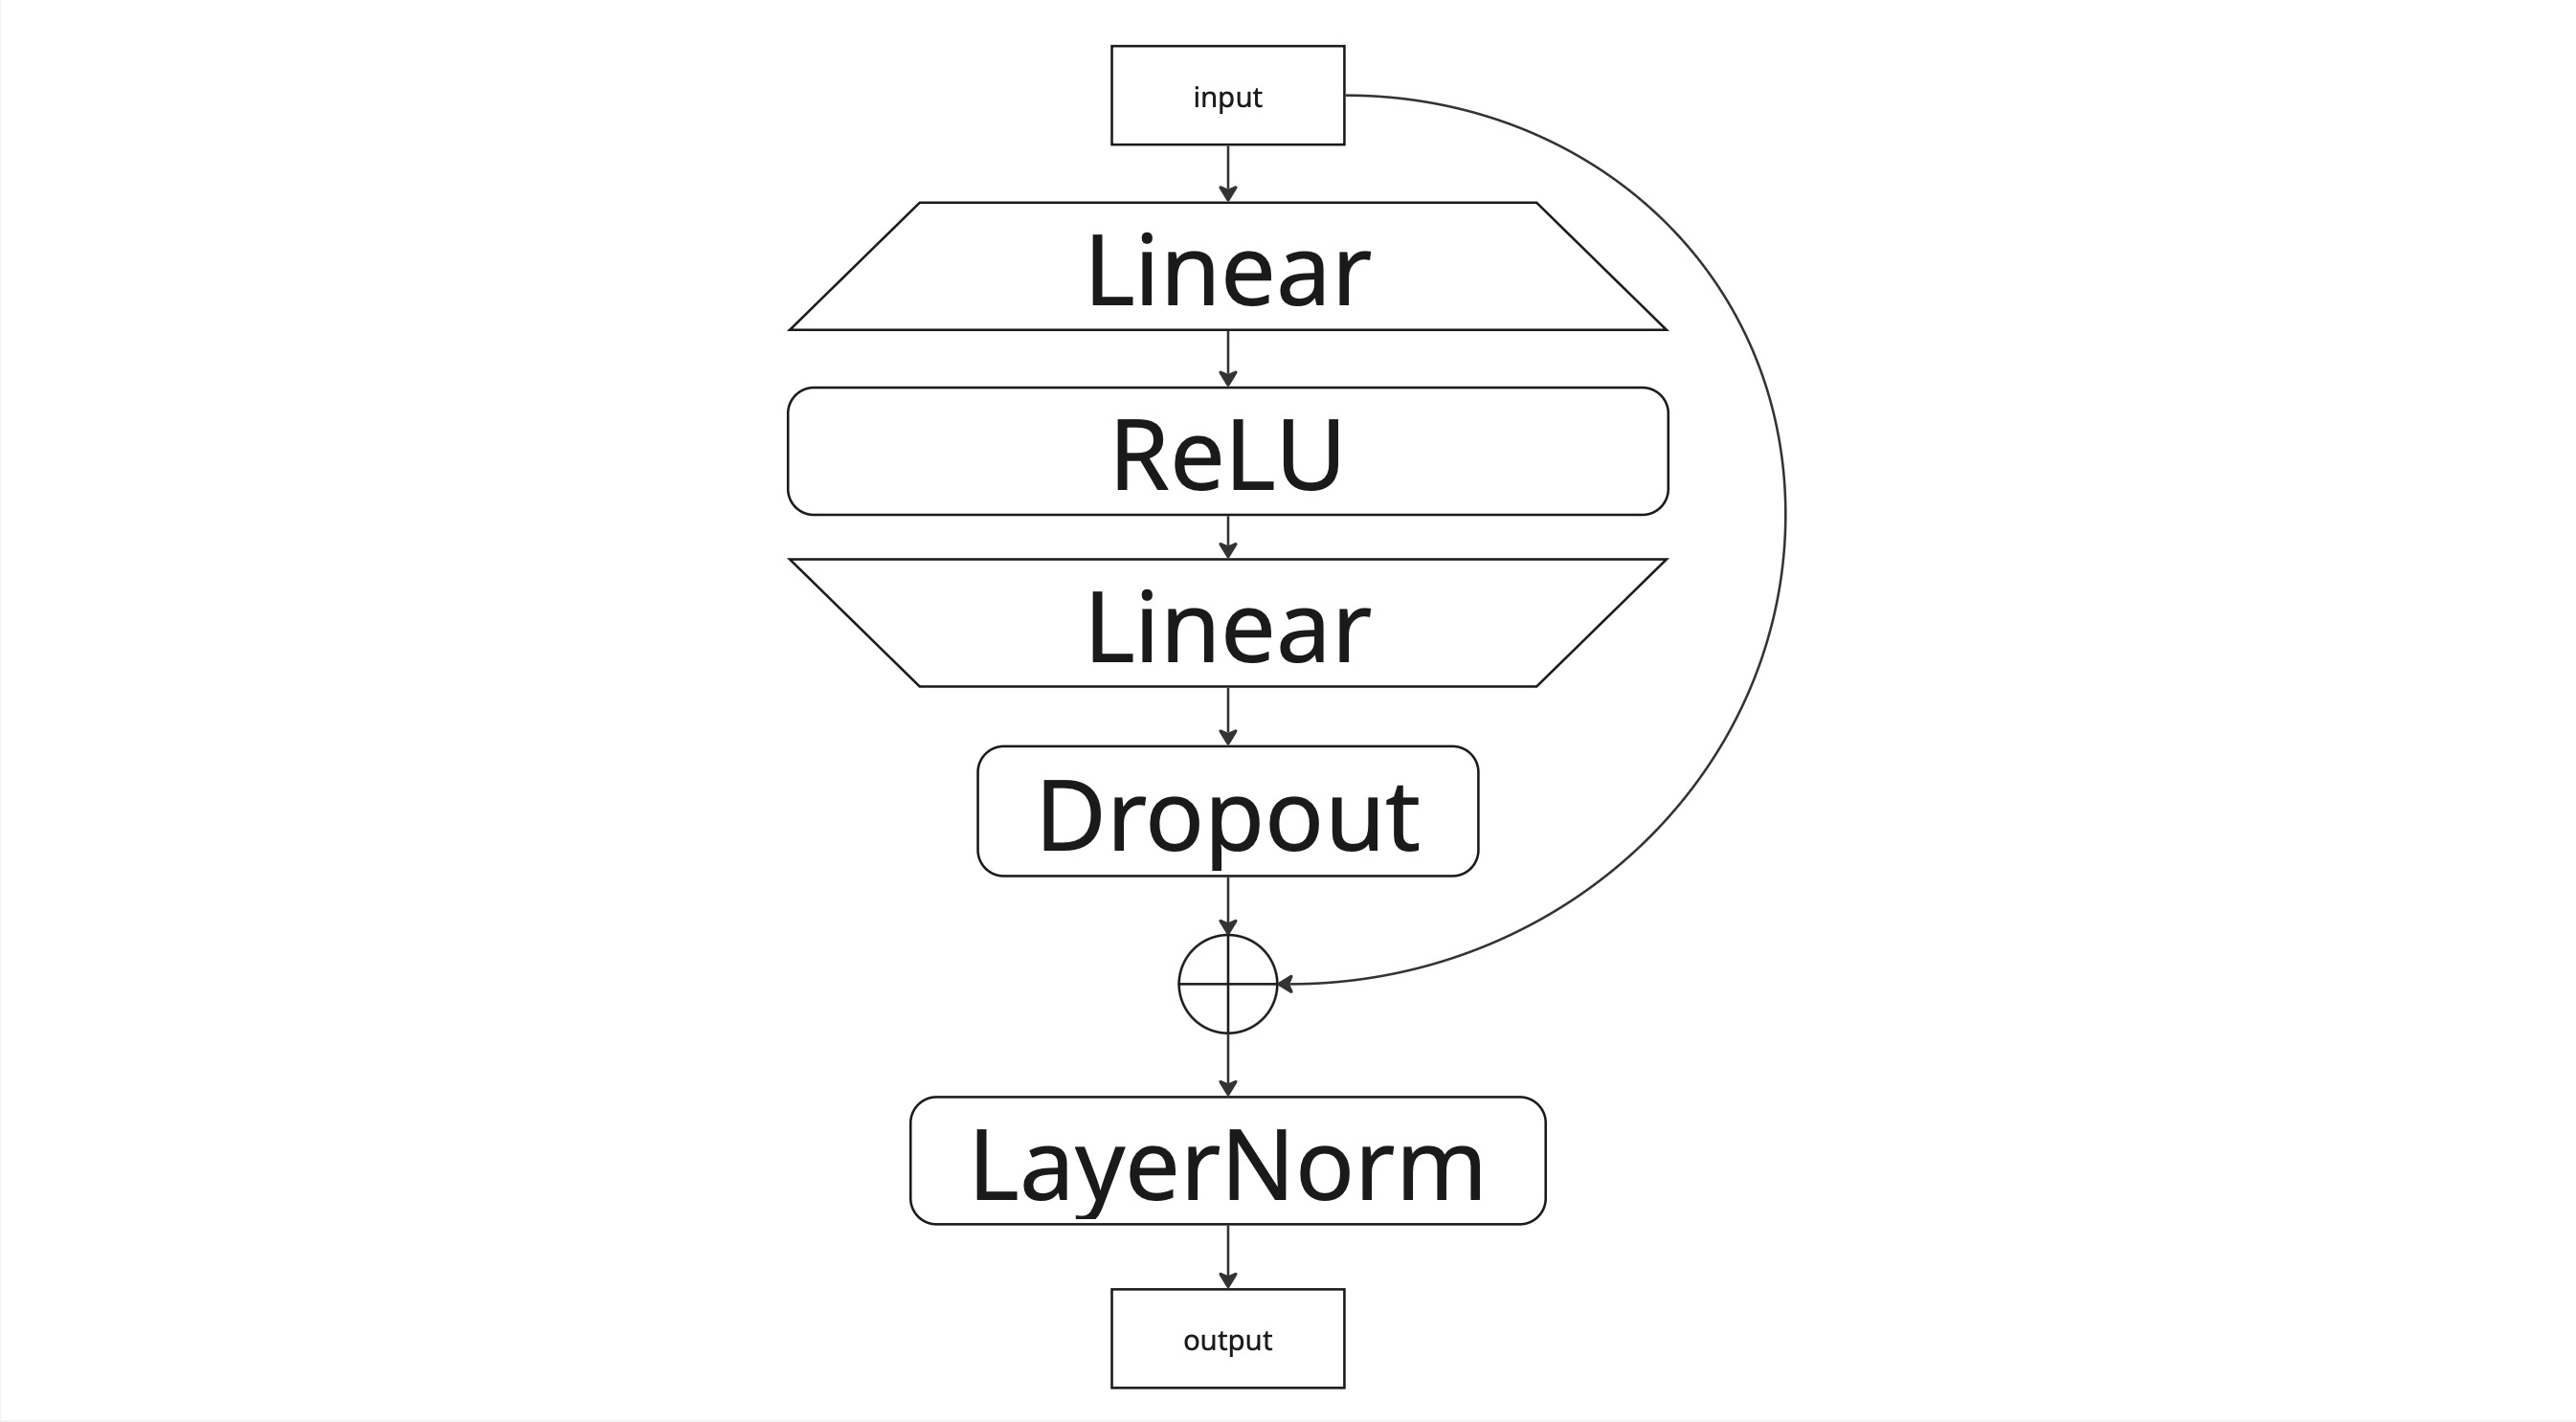

In [44]:
class MLPBlock(nn.Module):
    def __init__(self, dim, expand=4, dropout=0.0):
        super().__init__()
        self.mlp = nn.Sequential(
            #### ВАШ КОД ####
            nn.Linear(dim, dim * expand),
            nn.ReLU(),
            nn.Linear(dim * expand, dim),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # return ... # ВАШ КОД
        residual = x
        x = self.mlp(x)
        x = residual + x
        x = self.norm(x)
        return x


#### 2. `MLPActHead` — голова политики 2 балла

Эта сеть принимает **стекированное состояние** (вектор размерности `state_dim`) и предсказывает **действие** (вектор размерности `act_dim`).  
Особенность архитектуры — **многократное возвращение к исходному состоянию** на промежуточных этапах:

1. **Первый этап**:  
   - Состояние проецируется в скрытое пространство `hidden_dim` → `proj0`.  
   - Обрабатывается через `MLPBlock` → `block0`.

2. **Второй этап**:  
   - К текущему скрытому представлению **конкатенируется исходное состояние** (`[x, state]`).  
   - Результат проецируется в `hidden_dim` → `proj1`.  
   - Обрабатывается через `MLPBlock` → `block1`.

3. **Третий этап**:  
   - Снова конкатенируется исходное состояние → `[x, state]`.  
   - Проекция → `proj2`, затем `block2`.

4. **Финальный выход**:  
   - Линейная проекция `proj_end` преобразует скрытое представление в пространство действий.



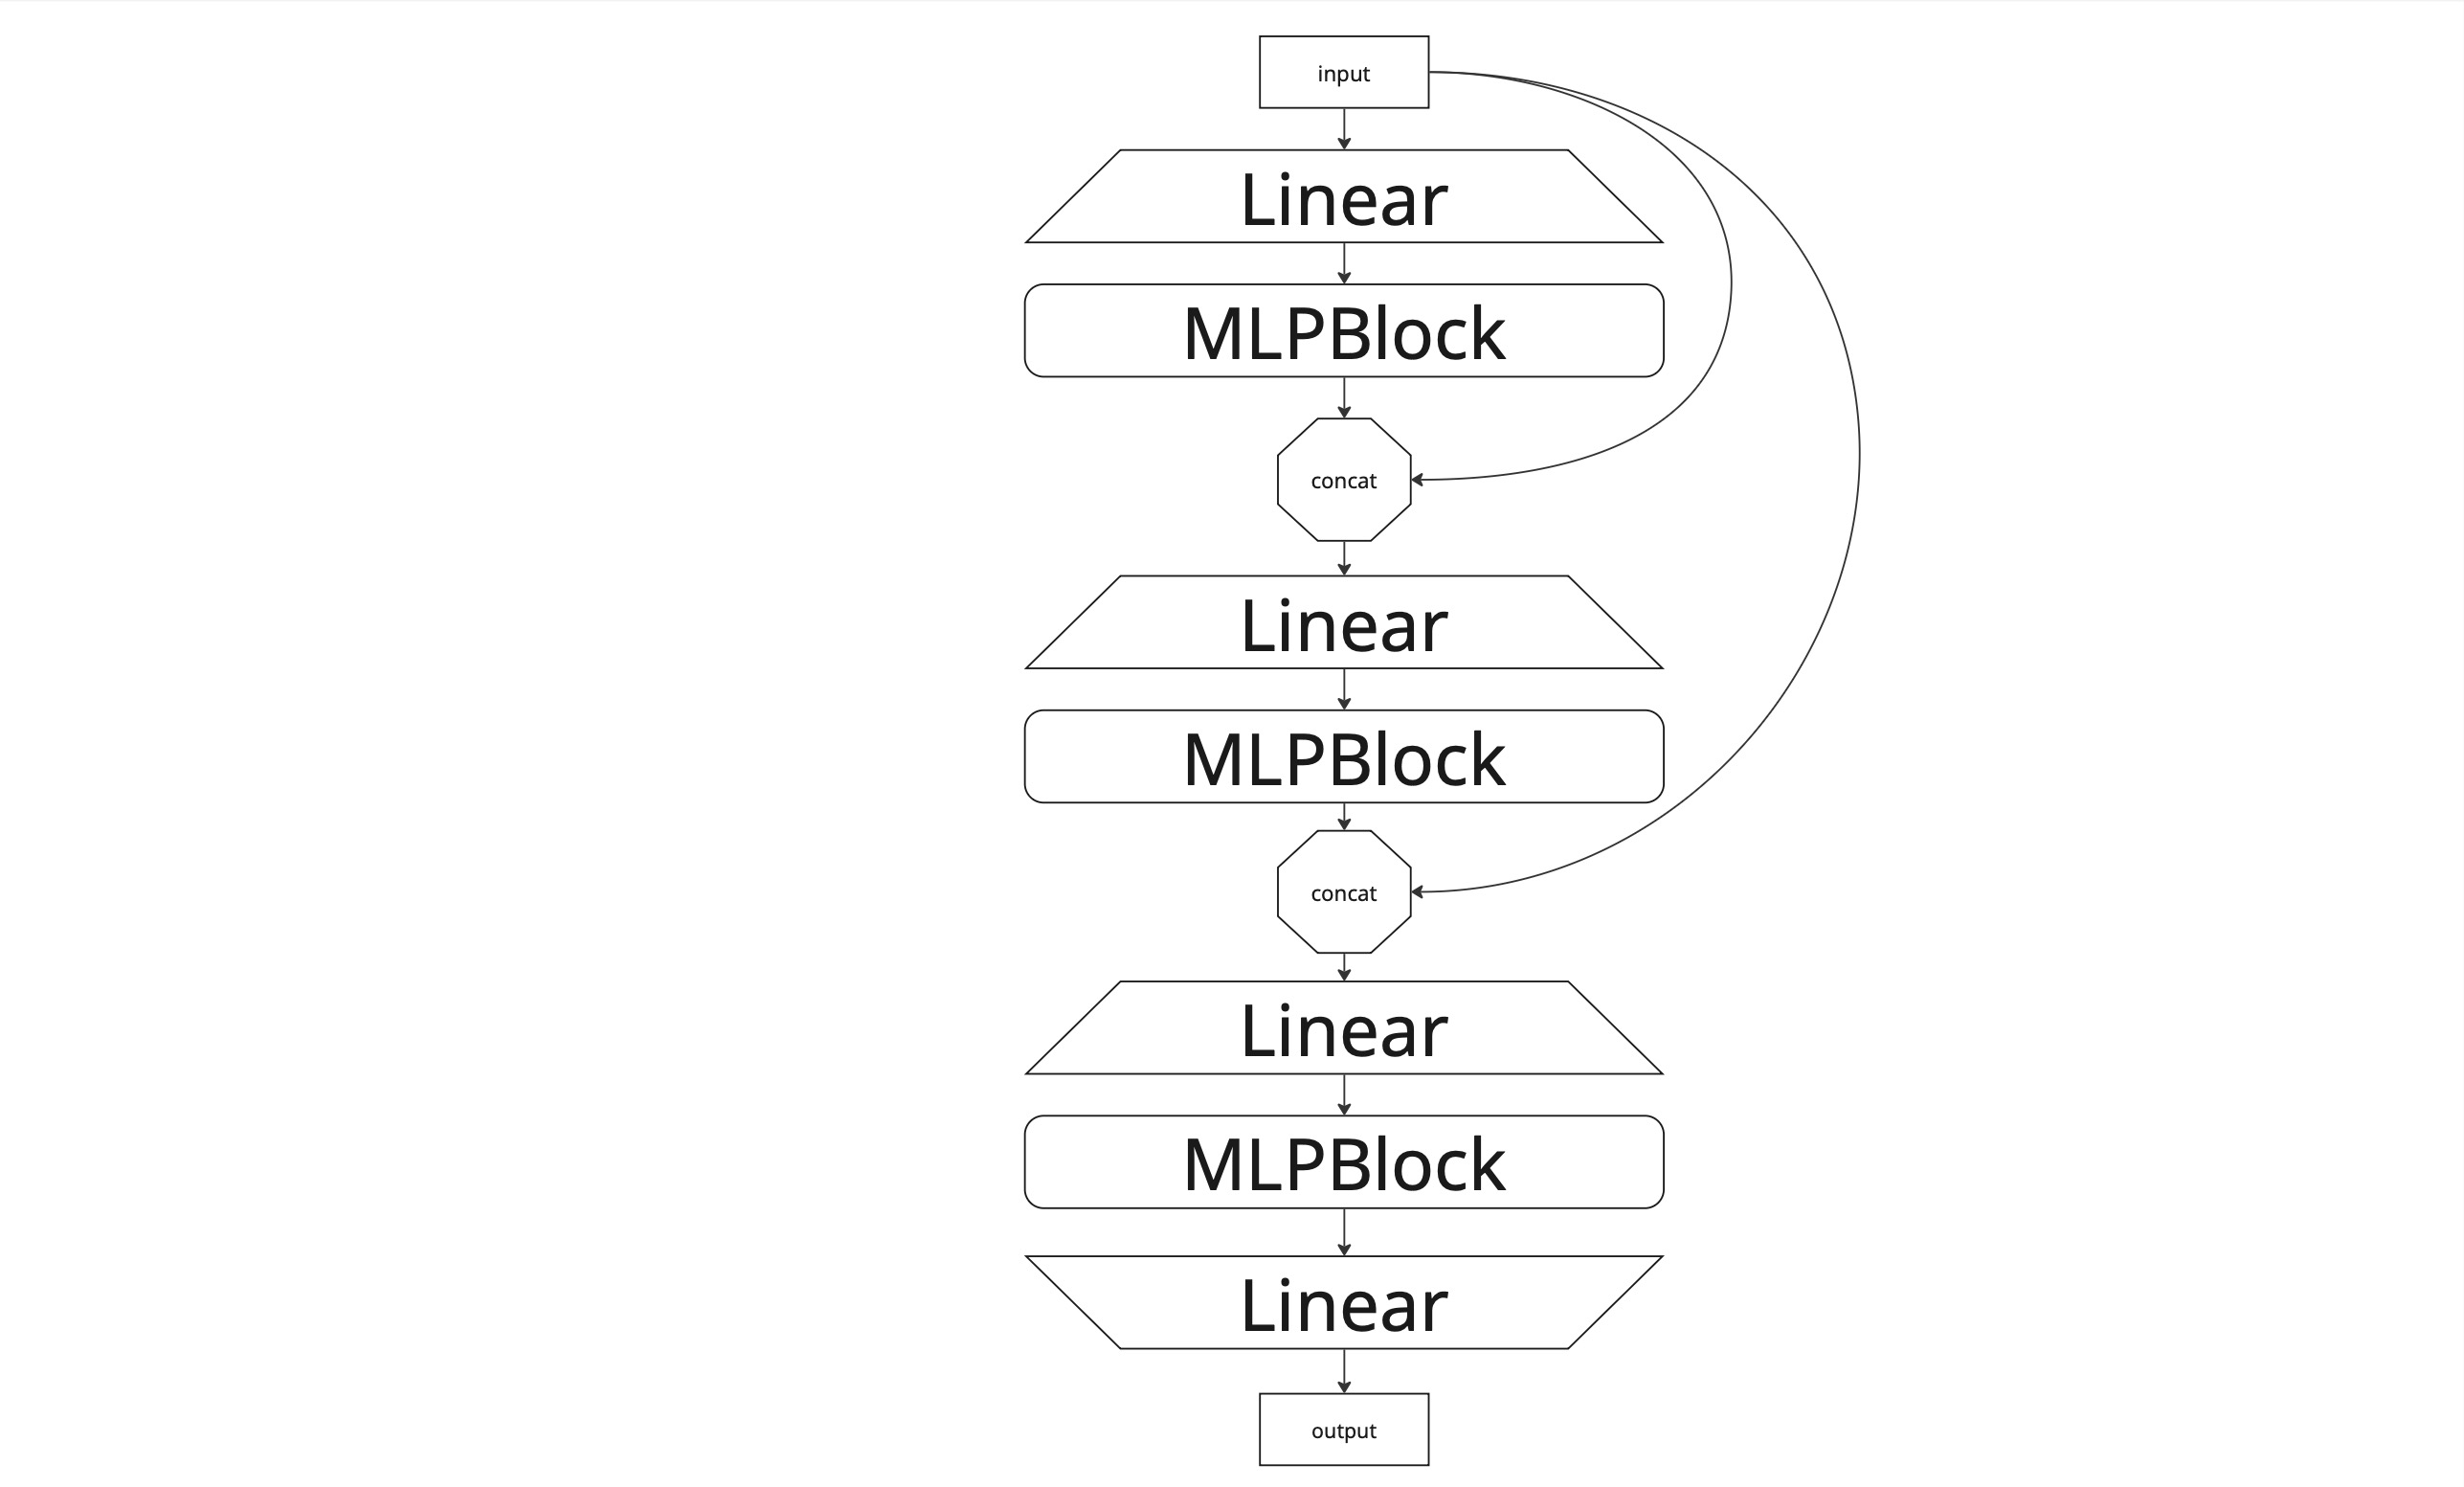

> 💡 **Зачем конкатенировать исходное состояние несколько раз?**  
> Это позволяет сети на каждом этапе «вспоминать» исходные признаки, не теряя контекст. Особенно полезно, когда `state_dim` велико, а промежуточные представления могут «забыть» важные детали. Такой приём используется в современных архитектурах (например, в ResNet с identity skip-connections или в некоторых transformer-based policy heads).

In [45]:
class MLPActHead(nn.Module):
    def __init__(self, act_dim, state_dim, hidden_dim, expand=4, dropout=0.0):
        super().__init__()
        #### ВАШ КОД ####
        self.proj0 = nn.Linear(state_dim, hidden_dim)
        self.block0 = MLPBlock(hidden_dim, expand, dropout)

        self.proj1 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block1 = MLPBlock(hidden_dim, expand, dropout)

        self.proj2 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block2 = MLPBlock(hidden_dim, expand, dropout)

        self.proj_end = nn.Linear(hidden_dim, act_dim)

    def forward(self, state):
        #### ВАШ КОД ###
        x = self.proj0(state)
        x = self.block0(x)

        x = torch.cat([x, state], dim=-1)
        x = self.proj1(x)
        x = self.block1(x)

        x = torch.cat([x, state], dim=-1)
        x = self.proj2(x)
        x = self.block2(x)

        action = self.proj_end(x)
        return action


In [46]:
bc_actor = MLPActHead(dataset.action_dim, dataset.state_dim * frame_stack, 32).to(device)

In [47]:
import torchinfo

torchinfo.summary(
    bc_actor, input_size=[(1, dataset.state_dim * frame_stack)]
)


Layer (type:depth-idx)                   Output Shape              Param #
MLPActHead                               [1, 6]                    --
├─Linear: 1-1                            [1, 32]                   1,120
├─MLPBlock: 1-2                          [1, 32]                   --
│    └─Sequential: 2-1                   [1, 32]                   --
│    │    └─Linear: 3-1                  [1, 128]                  4,224
│    │    └─ReLU: 3-2                    [1, 128]                  --
│    │    └─Linear: 3-3                  [1, 32]                   4,128
│    │    └─Identity: 3-4                [1, 32]                   --
│    └─LayerNorm: 2-2                    [1, 32]                   64
├─Linear: 1-3                            [1, 32]                   2,144
├─MLPBlock: 1-4                          [1, 32]                   --
│    └─Sequential: 2-3                   [1, 32]                   --
│    │    └─Linear: 3-5                  [1, 128]                  4,224


## Обучение Behavioral Cloning (1 балл)

На этом этапе вы обучаете нейросеть **методом Behavioral Cloning (BC)** — простейшей формы imitation learning, при которой агент обучается **регрессии**: по входному состоянию предсказывать действие, которое совершил эксперт.

1. **Оптимизатор**  
   Используется `AdamW` с раздельной настройкой weight decay:
   - Для матриц (параметров размерности ≥2) — применяется регуляризация.
   - Для векторов (смещения, scale-параметры) — регуляризация отключена, чтобы не повредить адаптивные характеристики модели.

In [48]:
def get_optim_groups(model, weight_decay):
    return [
        # do not decay biases and single-column parameters (rmsnorm), those are usually scales
        {"params": (p for p in model.parameters() if p.dim() < 2), "weight_decay": 0.0},
        {
            "params": (p for p in model.parameters() if p.dim() >= 2),
            "weight_decay": weight_decay,
        },
    ]

learning_rate = 0.001

# init optimizer
optim = torch.optim.AdamW(
    params=get_optim_groups(bc_actor, 0.0),
    lr=learning_rate,
    fused=True,
)


2. **Планировщик скорости обучения** (learning rate scheduling)
   Реализован линейный **warmup + decay**:  
   - Сначала learning rate линейно растёт от 0 до максимума (в данном случае — сразу до максимума, так как `warmup_epochs = 0`),  
   - Затем линейно убывает до нуля к концу обучения.  
   Это стабилизирует ранние шаги обучения и улучшает сходимость.

In [49]:
import torch
import math
import functools


def _linear_decay_warmup(iteration, warmup_iterations, total_iterations):
    """
    Linear warmup from 0 --> 1.0, then linear decay to 0
    """
    if iteration < warmup_iterations:
        multiplier = iteration / warmup_iterations
    else:
        multiplier = 1.0 - ((iteration - warmup_iterations) / (total_iterations - warmup_iterations))
    return multiplier


def linear_annealing_with_warmup(optimizer, warmup_steps, total_steps):
    _decay_func = functools.partial(
        _linear_decay_warmup,
        warmup_iterations=warmup_steps,
        total_iterations=total_steps,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _decay_func)
    return scheduler


In [50]:
num_epochs = 10
warmup_epochs = 0

total_updates = len(dataloader) * num_epochs
warmup_updates = len(dataloader) * warmup_epochs
scheduler = linear_annealing_with_warmup(optim, warmup_updates, total_updates)


3. **Функция потерь**  
   Используется **среднеквадратичная ошибка (MSE)** между предсказанным действием и действием эксперта:
   $$
   \mathcal{L} = \frac{1}{N} \sum_{i=1}^N \| a_{\text{pred}}^{(i)} - a_{\text{expert}}^{(i)} \|^2
   $$

In [51]:
import torch.nn.functional as F

for epoch in trange(num_epochs, desc="Epochs"):
    losses, n = 0, 0
    bc_actor.train()
    for batch in dataloader:

        states, target_action = [b.to(device) for b in batch]

        pred_action = bc_actor(states)
        loss = F.mse_loss(pred_action, target_action) # ВАШ КОД

        losses += loss.item()
        n += batch_size

        optim.zero_grad(set_to_none=True)
        loss.backward()

        optim.step()
        scheduler.step()

    print(f"\n\nEpoch {epoch} latest batch loss:\n{losses / n}")

Epochs:  10%|█         | 1/10 [00:38<05:42, 38.11s/it]



Epoch 0 latest batch loss:
0.008705730864166981


Epochs:  20%|██        | 2/10 [01:15<05:02, 37.86s/it]



Epoch 1 latest batch loss:
0.0018561371914838673


Epochs:  30%|███       | 3/10 [01:53<04:24, 37.72s/it]



Epoch 2 latest batch loss:
0.0015244743818911956


Epochs:  40%|████      | 4/10 [02:31<03:47, 37.97s/it]



Epoch 3 latest batch loss:
0.0013429952285005128


Epochs:  50%|█████     | 5/10 [03:09<03:09, 37.98s/it]



Epoch 4 latest batch loss:
0.0012195252190940664


Epochs:  60%|██████    | 6/10 [03:47<02:31, 37.93s/it]



Epoch 5 latest batch loss:
0.001132531605020631


Epochs:  70%|███████   | 7/10 [04:25<01:53, 37.90s/it]



Epoch 6 latest batch loss:
0.0010606699996860698


Epochs:  80%|████████  | 8/10 [05:03<01:15, 37.90s/it]



Epoch 7 latest batch loss:
0.0010008480435062664


Epochs:  90%|█████████ | 9/10 [05:41<00:37, 37.90s/it]



Epoch 8 latest batch loss:
0.0009490021729579894


Epochs: 100%|██████████| 10/10 [06:18<00:00, 37.90s/it]



Epoch 9 latest batch loss:
0.0009024029728170718


4. **Оценка качества**  
   После обучения агент тестируется на 50 эпизодах в среде `cheetah/run`.  
   Важно: при оценке используется **та же глубина frame stacking**, что и при обучении (`frame_stack=2`), иначе входы будут несовместимы!

In [52]:
@torch.no_grad()
def evaluate_actor(
    env,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:
            obs_ = torch.tensor(obs.copy(), device=device)
            obs_ = obs_[None].contiguous()  # [1 dim]

            action = bc_actor(obs_)

            obs, reward, terminated, truncated, info = env.step(
                action.squeeze().cpu().numpy()
            )
            done = terminated or truncated
            total_reward += reward
        returns.append(total_reward)

    return np.array(returns)


> 💡 **Интерпретация результата**  
> Если вы видите низкую награду, это означает, что BC-агент **не смог обобщить** поведение эксперта.  
> Возможные причины:
> - недостаточно данных (попробуйте обучиться на 1000 траекториях, а не на 10),
> - несовпадение распределений (covariate shift): агент попадает в состояния, которых не было в экспертном датасете,
> - слишком агрессивное обучение (попробуйте уменьшить learning rate или добавить dropout).

> **Для получения 1 балла**:  
> - Корректно запустить обучение BC на вашем датасете,  
> - Продемонстрировать, что loss убывает,  
> - Получить **награду не ниже 700** при оценке на 50 эпизодах (это ~85% от экспертного результата).

In [53]:
env = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
returns = evaluate_actor(env, bc_actor, 50, 0)

In [54]:
print(f"{np.mean(returns):.0f} +- {np.std(returns):.0f}")
print(f"{iqm(returns):.0f} +- {iqm_std(returns):.0f}")

844 +- 18
847 +- 7


## Анализ зависимости качества BC от размера датасета (5 баллов)

В этом задании вы исследуете, **как размер экспертного датасета влияет на качество обученной политики**. Это важный вопрос в imitation learning: слишком маленький датасет приводит к переобучению, а слишком большой — к высоким вычислительным затратам.

- Обучите BC-агентов на подмножествах одного и того же датасета, используя разное количество траекторий:  
  **`[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]`**.
- Для каждого размера:
  1. Создайте `StackedDataset` с параметром `max_videos=N` (не нужно собирать отдельные HDF5-файлы!).
  2. Обучите новую сеть `MLPActHead` с нуля (важно: не дообучайте старую!).
  3. Оцените политику на **50 эпизодах** с фиксированным `seed=0`.
- В качестве метрики используйте **IQM (Interquartile Mean)** и **стандартное отклонение по IQM** (см. функции `iqm`, `iqm_std` из предыдущего раздела).

## Постройте графики:
  - **Ось X**: количество траекторий в датасете (логарифмический масштаб рекомендуется).
  - **Ось Y**: `IQM ± IQM_STD`,`MEAN ± STD`(2 графика) награды BC-агента: 2 кривые
    1. **In-distribution**: используйте те же сиды, что и в датасете (`seed=0, 1, ..., 49`).
    2. **Out-of-distribution**: используйте новые сиды, которых **нет в датасете** (`seed=5000, 5001, ..., 5049`).

    > 💡 **Зачем это нужно?**  
    > Экспертный датасет собран с `seed=0..999`. Если вы оцениваете BC на `seed=0..49`, агент может «вспомнить» поведение из датасета (особенно при малом числе траекторий). Оценка на новых сидах покажет **настоящую обобщающую способность**.

#### Советы:
- Используйте одинаковые гиперпараметры (learning rate, batch size, архитектуру) для всех запусков.
- Сохраняйте результаты в список/словарь, чтобы построить график в конце.


In [59]:
#### ВАШ КОД ####
# разное количество траекторий
dataset_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
results_id = []
results_ood = []

# гиперпараметры для обучения
train_config = {
    'num_epochs': 10,
    'learning_rate': 0.001,
    'batch_size': 64,
    'hidden_dim': 256,
    'dropout': 0.1
}

def evaluate_model(env, actor, num_episodes=50, seed=0):
    """Оценивает модель в среде и возвращает метрики"""
    returns = evaluate_actor(env, actor, num_episodes=num_episodes, seed=seed)

    return {
        'mean': np.mean(returns),
        'std': np.std(returns),
        'iqm': iqm(returns),
        'iqm_std': iqm_std(returns),
        'returns': returns
    }

def train_bc_actor(train_dataset, device, config):
    """Обучает BC агента"""
    # DataLoader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=min(config['batch_size'], len(train_dataset)),
        shuffle=True
    )

    # модель
    bc_actor = MLPActHead(
        act_dim=env.action_space.shape[0],
        state_dim=np.prod(env.observation_space.shape),
        hidden_dim=config['hidden_dim'],
        dropout=config['dropout']
    ).to(device)

    # оптимизатор и scheduler
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=config['learning_rate'],
        fused=True
    )

    total_updates = len(train_dataloader) * config['num_epochs']
    scheduler = linear_annealing_with_warmup(optim, 0, total_updates)

    # Цикл обучения
    for epoch in trange(config['num_epochs'], desc="Epochs", leave=False):
        bc_actor.train()
        for batch in train_dataloader:
            states, target_actions = [b.to(device) for b in batch]

            pred_actions = bc_actor(states)
            loss = F.mse_loss(pred_actions, target_actions)

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            scheduler.step()

    return bc_actor



# цикл экспериментов
for size in dataset_sizes:
    print(f"\nОбучение - {size} траектории")

    # Создаем датасет
    train_dataset = StackedDataset(
        hdf5_path=dataset_path,
        frame_stack=frame_stack,
        max_videos=size
    )

    # Обучение модели
    bc_actor = train_bc_actor(train_dataset, device, train_config)

    # in-distribution оценка
    env_id = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
    results_id.append({
        'size': size,
        **evaluate_model(env_id, bc_actor, num_episodes=50, seed=0)
    })
    env_id.close()

    # out-of-distribution оценка
    env_ood = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
    results_ood.append({
        'size': size,
        **evaluate_model(env_ood, bc_actor, num_episodes=50, seed=5000)
    })
    env_ood.close()

    # Вывод результатов
    in_d_iqm = results_id[-1]['iqm']
    out_d_iqm = results_ood[-1]['iqm']
    in_d_iqm_std = results_id[-1]['iqm_std']
    out_d_iqm_std = results_ood[-1]['iqm_std']

    print(f"In-Distribution:  {in_d_iqm:.1f} ± {in_d_iqm_std:.1f}")
    print(f"Out-of-Distribution: {out_d_iqm:.1f} ± {out_d_iqm_std:.1f}")
    print(f"Разница между: {in_d_iqm - out_d_iqm:.1f}")

print("\n Done!")


Обучение - 2 траектории
Loaded 2 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  9.1 ± 1.2
Out-of-Distribution: 9.7 ± 1.1
Разница между: -0.5

Обучение - 4 траектории
Loaded 4 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  96.9 ± 19.8
Out-of-Distribution: 98.9 ± 15.7
Разница между: -2.1

Обучение - 8 траектории
Loaded 8 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  103.7 ± 26.4
Out-of-Distribution: 108.6 ± 27.1
Разница между: -4.9

Обучение - 16 траектории
Loaded 16 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  132.5 ± 37.4
Out-of-Distribution: 129.2 ± 49.3
Разница между: 3.4

Обучение - 32 траектории
Loaded 32 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  175.0 ± 48.7
Out-of-Distribution: 223.8 ± 63.3
Разница между: -48.8

Обучение - 64 траектории
Loaded 64 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  453.2 ± 172.0
Out-of-Distribution: 499.8 ± 230.1
Разница между: -46.7

Обучение - 128 траектории
Loaded 128 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  828.1 ± 20.9
Out-of-Distribution: 812.5 ± 27.5
Разница между: 15.6

Обучение - 256 траектории
Loaded 256 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  833.9 ± 8.4
Out-of-Distribution: 839.8 ± 8.6
Разница между: -5.9

Обучение - 512 траектории
Loaded 512 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  845.0 ± 6.2
Out-of-Distribution: 844.3 ± 5.1
Разница между: 0.7

Обучение - 1024 траектории
Loaded 1024 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


In-Distribution:  842.4 ± 4.0
Out-of-Distribution: 847.0 ± 5.3
Разница между: -4.6

 Done!


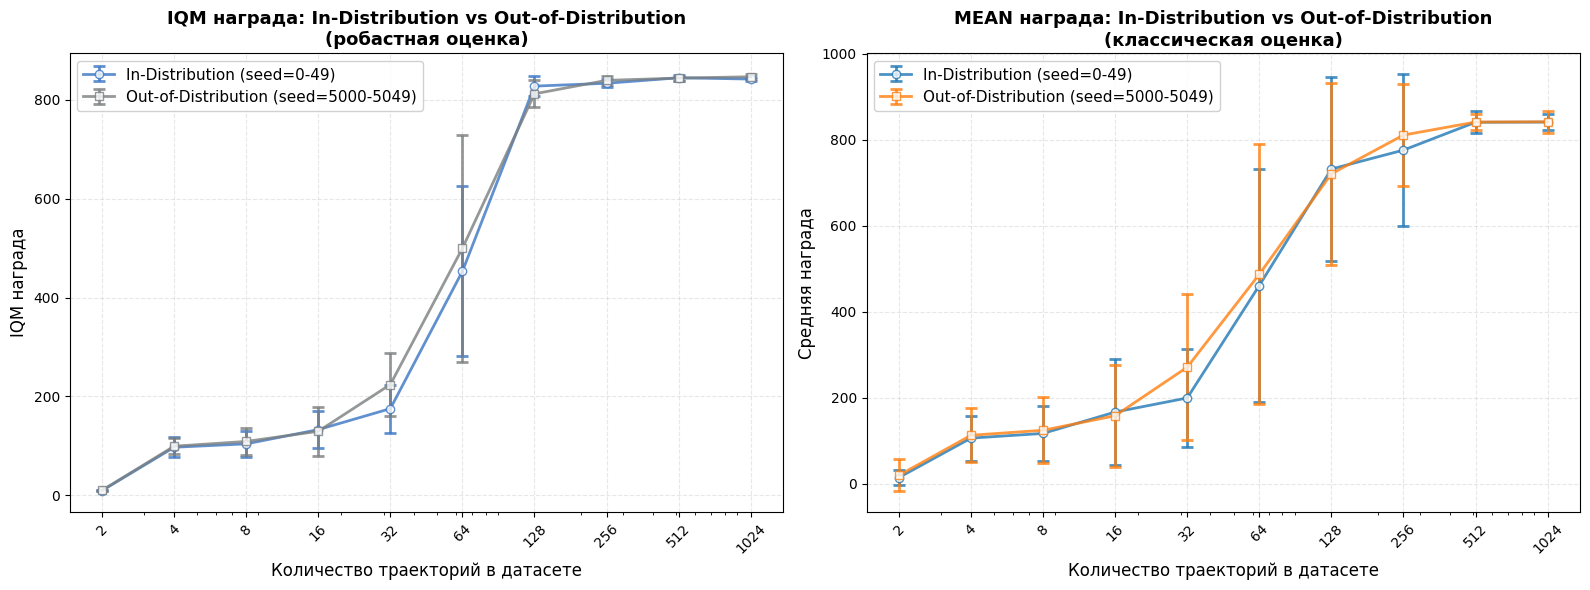

In [61]:
#### ВАШ КОД ####
# Построение графиков
import matplotlib.pyplot as plt
import numpy as np

# Данные для размера графиков
sizes = [r['size'] for r in results_id]

# для nn-distribution оценки
mean_id = [r['mean'] for r in results_id]
std_id = [r['std'] for r in results_id]
iqm_id = [r['iqm'] for r in results_id]
iqm_std_id = [r['iqm_std'] for r in results_id]

# для out-of-distribution оценки
mean_ood = [r['mean'] for r in results_ood]
std_ood = [r['std'] for r in results_ood]
iqm_ood = [r['iqm'] for r in results_ood]
iqm_std_ood = [r['iqm_std'] for r in results_ood]

# Строим два графика
# Ось X: количество траекторий в датасете (логарифмический масштаб рекомендуется).
# Ось Y: 1 график IQM ± IQM_STD, 2 график MEAN ± STD награды BC-агента

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# для IQM оценок
ax1.errorbar(sizes, iqm_id, yerr=iqm_std_id, fmt='-o', linewidth=2, markersize=6,
             capsize=4, capthick=2, label='In-Distribution (seed=0-49)',
             color='#3a75c4', alpha=0.8, markerfacecolor='white')
ax1.errorbar(sizes, iqm_ood, yerr=iqm_std_ood, fmt='-s', linewidth=2, markersize=6,
             capsize=4, capthick=2, label='Out-of-Distribution (seed=5000-5049)',
             color='#7a7e7f', alpha=0.8, markerfacecolor='white')
ax1.set_xscale('log')
ax1.set_xlabel('Количество траекторий в датасете', fontsize=12)
ax1.set_ylabel('IQM награда', fontsize=12)
ax1.set_title('IQM награда: In-Distribution vs Out-of-Distribution\n(робастная оценка)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, framealpha=0.9)
ax1.set_xticks(dataset_sizes)
ax1.set_xticklabels(dataset_sizes, rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=10)

# для классических оценок
ax2.errorbar(sizes, mean_id, yerr=std_id, fmt='-o', linewidth=2, markersize=6,
             capsize=4, capthick=2, label='In-Distribution (seed=0-49)',
             color='#1f77b4', alpha=0.8, markerfacecolor='white')
ax2.errorbar(sizes, mean_ood, yerr=std_ood, fmt='-s', linewidth=2, markersize=6,
             capsize=4, capthick=2, label='Out-of-Distribution (seed=5000-5049)',
             color='#ff7f0e', alpha=0.8, markerfacecolor='white')
ax2.set_xscale('log')
ax2.set_xlabel('Количество траекторий в датасете', fontsize=12)
ax2.set_ylabel('Средняя награда', fontsize=12)
ax2.set_title('MEAN награда: In-Distribution vs Out-of-Distribution\n(классическая оценка)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.set_xticks(dataset_sizes)
ax2.set_xticklabels(dataset_sizes, rotation=45)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


## Dagger  (5 баллов)

**Behavioral Cloning (BC)** страдает от так называемого **covariate shift**: обученная политика может отклониться от экспертной траектории и попасть в состояния, которых не было в датасете. В таких состояниях она ведёт себя непредсказуемо, что усугубляет ошибку — и так далее.

Алгоритм **DAgger (Dataset Aggregation)** решает эту проблему **итеративно**:
1. На каждой итерации агент собирает траектории, используя **текущую политику**.
2. Для каждого посещённого состояния запрашивается **действие от эксперта**.
3. Пары `(состояние, экспертное_действие)` добавляются в обучающий датасет.
4. Политика переобучается на расширенном датасете.

#### 🔧 Вспомогательные компоненты

Чтобы упростить реализацию, мы рекомендуем использовать:

1. **`UpdateDataset`** — наследник `StackedDataset`, который поддерживает метод `.update(new_states, new_actions)`.  
   → **Важно**: передавайте **исходные состояния** (`obs` размерности 17), **НЕ стекированные**!  
   → Датасет сам позаботится о frame stacking при обучении.

In [65]:
class UpdateDataset(StackedDataset):

    def update(self, new_states, new_actions):
        state_dim = self.states[0].shape[-1]
        assert state_dim == self.state_dim, "Your state_dim in new_states != state_dim in dataset. Check that you do NOT collect frame_stacked states."

        new_states = [torch.tensor(s, device=self.device) for s in new_states]
        new_actions = [torch.tensor(a, device=self.device) for a in new_actions]

        self.states.extend(new_states)
        self.actions.extend(new_actions)

        self.traj_len = self.states[0].shape[0]

In [66]:
dataset = UpdateDataset(dataset_path, frame_stack, device, max_videos=1024) # ВАШ КОД)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 1024 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5


2. **`log_actor_trajectories_with_expert_actions(...)`** — функция, которая:
   - Собирает траектории с помощью **вашего BC-агента**,
   - Для **каждого состояния** запрашивает **действие у эксперта**,
   - Возвращает списки: `states` (исходные, не стекированные! (без frame-stack)), `actions` (экспертные), и `returns`.

In [67]:
@torch.no_grad()
def log_actor_trajectories_with_expert_actions(
    env,
    expert: Agent,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    states_arr = []
    actions_arr = []
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        states = []
        actions = []
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:

            #### ВАШ КОД ####
            # трактория собирается политикой BC-агента
            # действия логгируются от эксперта
            # также логгируются returns для оценки текущей политики BC-агента

            # действие от BC-агента для текущего состояния
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            bc_action_tensor = bc_actor(obs_tensor)
            bc_action = bc_action_tensor.squeeze(0).cpu().numpy()

            # действие для текущего состояния от эксперта
            original_obs_for_expert = obs[-obs.shape[0] // frame_stack:]
            expert_action = expert.act_numpy(original_obs_for_expert, greedy=True)

            states.append(original_obs_for_expert)
            actions.append(expert_action)

            # Выполняем действие BC-агента в среде
            next_obs, reward, terminated, truncated, _ = env.step(bc_action)
            done = terminated or truncated

            # суммарная награда
            total_reward += reward
            obs = next_obs
            #### ВАШ КОД ####

        returns.append(total_reward)
        states_arr.append(np.array(states))
        actions_arr.append(np.array(actions))

    return states_arr, actions_arr, np.array(returns)


In [68]:
states, actions, returns = log_actor_trajectories_with_expert_actions(env, expert, bc_actor, num_episodes=2, seed=123)

#### Требования к реализации

Выполните **5-10 итераций DAgger**:

- **Инициализация**:  
  Инициализируйте `UpdateDataset` с `max_videos=100` (или 50–300) — это ваш стартовый датасет от эксперта.

- **На каждой итерации**:
  1. Создайте **новую сеть** `MLPActHead` (обучайте **с нуля**, не дообучайте!).
  2. Обучите её на **текущем датасете** (используйте тот же цикл обучения, что и в BC).
  3. Соберите **10-20 новых траекторий** с помощью `log_actor_trajectories_with_expert_actions(...)`.
  4. Обновите датасет: `dataset.update(states, actions)`.
  5. **Оцените** политику: выведите `IQM ± IQM_STD`,`MEAN ± STD` по возвращённым `returns`.

- **В конце**: постройте график `итерация → IQM`.

#### Что нужно для 5 баллов

- Корректная реализация цикла DAgger (10 итераций),
- Использование **экспертных действий** для состояний, порождённых **текущей политикой**,
- **Обучение BC-агента с нуля** на каждой итерации,
- Вывод **IQM и IQM_STD** после каждой итерации,
- **График** зависимости IQM от номера итерации,
- Интерпретация результатов: краткий **комментарий** (1–2 предложения) *сравнение DAgger и BC*
`
#### Пример структуры кода

```python
# Инициализация
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)
dagger_scores = ... # логгирование метрик для графика

for iteration in range(10):
    # 1. Создать и обучить новую политику
    bc_actor = MLPActHead(...).to(device)
    # ... (цикл обучения)

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=10, seed=5000 + iteration * 10
    )

    # 3. Обновить датасет
    dataset.update(states, actions)

    # 4. Вывести результат
    print(f"Iteration {iteration} → IQM: {iqm(returns):.1f} ± {iqm_std(returns):.1f}")
```

In [69]:
#### ВАШ КОД ####

# Инициализация
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)
dagger_scores = [] # логгирование метрик для графика

# гиперпараметры для обучения
train_config = {
    'num_epochs': 10,
    'learning_rate': 0.001,
    'batch_size': 64,
    'hidden_dim': 256,
    'dropout': 0.1
}

for iteration in range(10):
    print(f"\nИтерация DAgger #{iteration + 1}")

    # 1. Создать и обучить новую политику
    train_dataloader = DataLoader(
        dataset,
        batch_size=min(train_config['batch_size'], len(dataset)),
        shuffle=True
    )

    bc_actor = MLPActHead(
        act_dim=env.action_space.shape[0],
        state_dim=np.prod(env.observation_space.shape),
        hidden_dim=train_config['hidden_dim'],
        dropout=train_config['dropout']
    ).to(device)

    # Настройка оптимизатора
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=train_config['learning_rate'],
        fused=True
    )

    total_updates = len(train_dataloader) * train_config['num_epochs']
    scheduler = linear_annealing_with_warmup(optim, 0, total_updates)

    # Цикл обучения
    for epoch in trange(train_config['num_epochs'], desc="Обучение BC", leave=False):
        bc_actor.train()
        for batch in train_dataloader:
            states, target_actions = [b.to(device) for b in batch]

            pred_actions = bc_actor(states)
            loss = F.mse_loss(pred_actions, target_actions)

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            scheduler.step()

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=10, seed=5000 + iteration * 10
    )

    # 3. Обновить датасет
    dataset.update(states, actions)

    # 4. Оценка и сохранение результатов
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    iqm_return = iqm(returns)
    iqm_std_return = iqm_std(returns)

    dagger_scores.append({
        'iteration': iteration + 1,
        'mean': mean_return,
        'std': std_return,
        'iqm': iqm_return,
        'iqm_std': iqm_std_return,
        'returns': returns,
        'dataset_size': len(dataset)
    })

    # Вывод результатов
    print(f"   IQM ± IQM_STD:  {iqm_return:.1f} ± {iqm_std_return:.1f}")
    print(f"   MEAN ± STD: {mean_return:.1f} ± {std_return:.1f}")

env.close()

Loaded 100 trajectories from /content/drive/MyDrive/cheetah-run-expert.hdf5

Итерация DAgger #1


   IQM ± IQM_STD:  703.8 ± 75.3
   MEAN ± STD: 605.8 ± 253.7

Итерация DAgger #2


   IQM ± IQM_STD:  843.2 ± 6.5
   MEAN ± STD: 836.0 ± 24.6

Итерация DAgger #3


   IQM ± IQM_STD:  840.0 ± 4.5
   MEAN ± STD: 729.7 ± 243.2

Итерация DAgger #4


   IQM ± IQM_STD:  835.8 ± 5.2
   MEAN ± STD: 835.1 ± 19.4

Итерация DAgger #5


   IQM ± IQM_STD:  847.9 ± 2.0
   MEAN ± STD: 845.5 ± 11.8

Итерация DAgger #6


   IQM ± IQM_STD:  850.0 ± 5.1
   MEAN ± STD: 847.8 ± 13.8

Итерация DAgger #7


   IQM ± IQM_STD:  839.7 ± 1.5
   MEAN ± STD: 817.6 ± 74.9

Итерация DAgger #8


   IQM ± IQM_STD:  859.5 ± 3.5
   MEAN ± STD: 859.1 ± 11.4

Итерация DAgger #9


   IQM ± IQM_STD:  841.1 ± 13.0
   MEAN ± STD: 818.1 ± 56.3

Итерация DAgger #10


   IQM ± IQM_STD:  844.5 ± 2.0
   MEAN ± STD: 843.4 ± 10.6


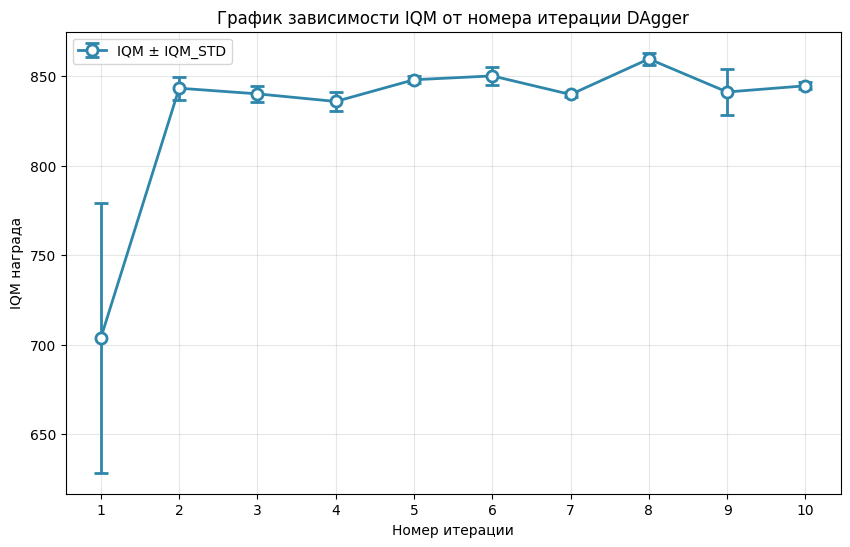

In [70]:
#### ВАШ КОД ####
# Подготовка данных для графиков
iterations = [r['iteration'] for r in dagger_scores]
iqm_scores = [r['iqm'] for r in dagger_scores]
iqm_stds = [r['iqm_std'] for r in dagger_scores]

# График зависимости IQM от номера итерации
plt.figure(figsize=(10, 6))
plt.errorbar(iterations, iqm_scores, yerr=iqm_stds, fmt='-o', linewidth=2,
             markersize=8, capsize=5, capthick=2, color='#2E86AB',
             markerfacecolor='white', markeredgewidth=2, label='IQM ± IQM_STD')

plt.xlabel('Номер итерации')
plt.ylabel('IQM награда')
plt.title('График зависимости IQM от номера итерации DAgger')
plt.grid(True, alpha=0.3)
plt.xticks(iterations)
plt.legend()
plt.show()

#### Интерпретация результатов: краткий комментарий (1–2 предложения) сравнение DAgger и BC ####

DAgger показывает более эффективное использование экспертных траекторий по сравнению с BC (при условии общего количества запросов к эксперту), при этом может достигать лучшего качества,  производительности. Это обосновывается тем, что алгоритм собирает корректирующие действия именно  релевантных состояниях (например, сложных состояниях, где текущая политика совершает ошибки).
